## Identifying Scaffolds in a Set of Molecules

### Introduction
In Cheminformatics, we frequently run into cases where we want to understand structure-activity relationships in a set of molecules.  In order to do this, we typically separate the molecules based on common scaffolds, then create an R-group table to explore the substituents that have been attached to the scaffold.  In addition, identifying scaffolds allows us to perform tasks like aligning molecules that will enable us to more easily compare the molecules.  In this notebook we'll use a method inspired by a 2019 paper by [Naveja, Vogt, Stumpfe, Medina-Franco, and Bajorath](https://pubs.acs.org/doi/full/10.1021/acsomega.8b03390). The method operates by carrying out three steps.

1. Decompose each molecule into a set of fragments.  In this case we'll use the [FragmentMol](https://www.rdkit.org/docs/source/rdkit.Chem.rdMMPA.html) function from the Matched Molecular Pair Analysis (MMPA) functions in the RDKit decompose a molecule into a set of fragments.  The RDKit MMPA methods use the [Hussain and Rea](https://pubs.acs.org/doi/10.1021/ci900450m) methodology, which fragments a molecule by successively disconnecting acyclic single bonds.
2. Remove any fragments where the number of atoms is less than 2/3 the number of atoms in the original molecule.
3. Collect fragments and records their frequency. We can do this easily using the Pandas [groupby](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.groupby.html) method.

All of these functions have been encapsulated in a small python library called scaffold_finder.  In this notebook, we'll use four functions from this library.
* generate_fragments - performs steps 1 and 2 above.
* find scaffolds - performs step 3 above
* cleanup_fragments - takes a set of fragments generated by steps 1 and 2 above, and coverts them to scaffolds
* get_molecules_with_scaffold - select molecules containing a specified fragment from a Pandas dataframe.


In order to run on Google Colab, you'll need to execute the cell below to install the rdkit, Pandas, and mols2grid. 

In [1]:
import sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    !pip install pandas requests mols2grid useful-rdkit-utils

Download the scaffold_finder library from GitHub.

In [45]:
import requests
lib_file = requests.get("https://raw.githubusercontent.com/PatWalters/practical_cheminformatics_tutorials/main/sar_analysis/scaffold_finder.py")
ofs = open("scaffold_finder.py","w")
print(lib_file.text,file=ofs)
ofs.close()

In [46]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.rdDepictor import Compute2DCoords
from io import StringIO
import mols2grid
from scaffold_finder import generate_fragments, find_scaffolds, get_molecules_with_scaffold, cleanup_fragment

### A Simple Example

As an example, let's consider four molecules from the paper by [Naveja, Vogt, Stumpfe, Medina-Franco, Bajorath](https://pubs.acs.org/doi/full/10.1021/acsomega.8b03390).

In [47]:
buff = """NS(=O)(=O)C1=CC=C(C=C1)C1=C(C(=O)NC1=O)C1=CC=CC=C1,mol_001
CN1C(=O)C(=C(C1=O)C1=CC=C(C=C1)S(N)(=O)=O)C1=CC=CC=C1,mol_002
COC1=CC=C(C=C1)C1=C(C(=O)N(C)C1=O)C1=CC=C(C=C1)S(N)(=O)=O,mol_003
COC1=CC=C(C=C1)C1=C(C(=O)NC1=O)C1=CC=C(C=C1)S(N)(=O)=O,mol_004
"""
fs = StringIO(buff)
df = pd.read_csv(fs,names=["SMILES","Name"])
df['mol'] = df.SMILES.apply(Chem.MolFromSmiles)

In [48]:
mols2grid.display(df,mol_col="mol",size=(200,200))

We'll begin with the first molecule.

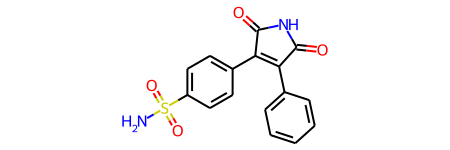

In [49]:
m0 = df.mol.values[0]
m0

First, we'll convert the molecule to fragments. 

In [50]:
m0_frag_df = generate_fragments(m0)
m0_frag_df

,Scaffold,NumAtoms,NumRgroupgs
0,O=C1NC(=O)C(c2ccccc2)=C1c1ccccc1,19,1
1,NS(=O)(=O)c1ccc(C2=CC(=O)NC2=O)cc1,17,1
2,NS(=O)(=O)c1ccc(C2=C(c3ccccc3)C(=O)NC2=O)cc1,23,1


In [51]:
mols2grid.display(m0_frag_df,smiles_col="Scaffold")

We can do the same thing with the second molecule. 

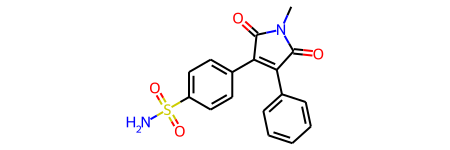

In [52]:
m1 = df.mol.values[1]
m1

In [53]:
m1_frag_df = generate_fragments(m1)
m1_frag_df

,Scaffold,NumAtoms,NumRgroupgs
0,NS(=O)(=O)c1ccc(C2=C(c3ccccc3)C(=O)NC2=O)cc1,23,1
1,NS(=O)(=O)c1ccc(C2=CC(=O)NC2=O)cc1,17,2
2,O=C1NC(=O)C(c2ccccc2)=C1c1ccccc1,19,2
3,CN1C(=O)C=C(c2ccc(S(N)(=O)=O)cc2)C1=O,18,1
4,CN1C(=O)C(c2ccccc2)=C(c2ccccc2)C1=O,20,1
5,CN1C(=O)C(c2ccccc2)=C(c2ccc(S(N)(=O)=O)cc2)C1=O,24,1


In [54]:
mols2grid.display(m1_frag_df,smiles_col="Scaffold")

Let's combine the fragments from m0 and m1 into one dataframe.

In [55]:
m0m1_frag_df = pd.concat([m0_frag_df,m1_frag_df])

We can then use Pandas **groupby** to record the frequency of occurrence of each fragment.

In [56]:
scaffold_list = []
for k,v in m0m1_frag_df.groupby("Scaffold"):
    scaffold_list.append([k,len(v),v.NumAtoms.values[0]])
scaffold_df = pd.DataFrame(scaffold_list,columns=["Scaffold","Count","NumAtoms"])

In [57]:
scaffold_df.sort_values(["Count","NumAtoms"],ascending=[False,False],inplace=True)

The table below records the frequency of occurrence of each fragment.

In [58]:
mols2grid.display(scaffold_df,smiles_col="Scaffold",subset=["img","Count","NumAtoms"])

We can use the function **find_scaffolds** to find scaffolds in the set of four molecules above. 

In [59]:
mol_df, scaf_df = find_scaffolds(df)
mols2grid.display(scaf_df,smiles_col="Scaffold",subset=["img","Count","NumAtoms"])

  0%|          | 0/4 [00:00<?, ?it/s]

### A More Substantial Example
Identifying scaffolds in a set of four molecules is a somewhat trivial problem.  Let's take a look at a larger set of molecules from the ChEMBL database. We'll start by reading the input data.

In [60]:
infile_url = "https://raw.githubusercontent.com/PatWalters/practical_cheminformatics_tutorials/main/data/CHEMBL208.smi"
chembl208_df = pd.read_csv(infile_url,names=["SMILES","Name","pIC50"])
chembl208_df.head()

,SMILES,Name,pIC50
0,O=c1[nH]c2ccc(-c3cccc(Cl)c3)cc2s1,CHEMBL94053,6.90
1,O=c1[nH]c2ccc(-c3cccc([N+](=O)[O-])c3)cc2n1Cc1...,CHEMBL327409,6.15
2,CC1=CC(C)(C)Nc2ccc(-c3cccc([N+](=O)[O-])c3)cc21,CHEMBL93027,7.70
3,CC(C)n1c(=O)[nH]c2ccc(-c3cccc(Cl)c3)cc21,CHEMBL329631,6.28
4,CC(C)n1c(=O)[nH]c2ccc(-c3cccc([N+](=O)[O-])c3)...,CHEMBL327444,6.28


First we'll add a column with RDKit molecules to the dataframe. 

In [61]:
chembl208_df['mol'] = chembl208_df.SMILES.apply(Chem.MolFromSmiles)

Next, we can identify scaffolds.

In [62]:
mol_df, scaffold_df = find_scaffolds(chembl208_df)

  0%|          | 0/513 [00:00<?, ?it/s]

Let's take a look at the scaffolds

In [63]:
scaffold_df

,Scaffold,Count,NumAtoms
5012,CC1=CC(C)(C)Nc2ccc3c(c21)COc1ccccc1-3,108,21
4312,CC1(C)C=Cc2c(ccc3c2COc2ccccc2-3)N1,93,20
5396,CC1=CC(C)Nc2ccc3c(c21)COc1ccccc1-3,92,20
2555,C=C1Oc2ccccc2-c2ccc3c(c21)C(C)=CC(C)(C)N3,64,22
2556,C=C1Oc2ccccc2-c2ccc3c(c21)C(C)=CC(C)N3,50,21
...,...,...,...
3933,CC(C)n1c(=O)[nH]c2ccccc21,1,13
11729,O=[SH](=O)Nc1ccc2cc[nH]c2c1,1,13
7372,CCn1c(=O)[nH]c2ccccc21,1,12
11001,Cn1c(=O)[nH]c2ccccc21,1,11


In [64]:
mols2grid.display(scaffold_df.head(10),smiles_col="Scaffold",subset=["img","Count"])

The scaffolds above are sorted by frequency.  We can look at the molecules containing the most frequently occurring scaffold by selecting the first scaffold in **scaffold_df**.

In [65]:
scaffold_0 = scaffold_df.Scaffold.values[0]

The function **get_molecules_with_scaffold** will return all the molecules containing the specified scaffold. This function returns two values.
* A list of scaffolds with R-group substitution points labeled
* A dataframe with molecules containing that scaffold

In [66]:
scaffold_smiles_list, chembl208_mol_df = get_molecules_with_scaffold(scaffold_0, mol_df, chembl208_df)

Let's look at the scaffold with R-group labels. 

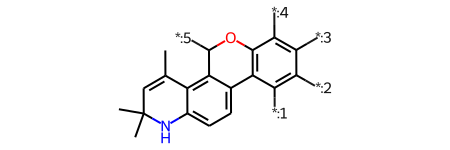

In [67]:
scaffold_mol = Chem.MolFromSmiles(scaffold_smiles_list[0])
scaffold_mol

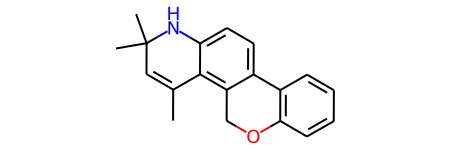

In [68]:
clean_scaffold_mol, _ = cleanup_fragment(scaffold_mol)
Compute2DCoords(clean_scaffold_mol)
clean_scaffold_mol

With this scaffold in hand, we can generate aligned structures for the molecules. 

In [69]:
chembl208_mol_df['mol'] = chembl208_mol_df.SMILES.apply(Chem.MolFromSmiles)

In [70]:
for mol in chembl208_mol_df.mol:
    AllChem.GenerateDepictionMatching2DStructure(mol,clean_scaffold_mol)

In [71]:
mols2grid.display(chembl208_mol_df.sort_values("pIC50",ascending=False),
                  mol_col='mol',use_coords=True, prerender=True, substruct_highlight=False,
                  transform={"pIC50" : lambda x: f"{x:.1f}"},
                  subset=["img","Name","pIC50"])